In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/file-srt/Dataset srt/R/M3GAN.2022.1080p.WEB.H264-NAISU.srt
/kaggle/input/file-srt/Dataset srt/R/John.Wick.Chapter.3.Parabellum.2019.720p.BluRay.x264-.YTS.LT.-HI.srt
/kaggle/input/file-srt/Dataset srt/R/The.Voyeurs.2021.1080p.AMZN.WEB-DL.DDP5.1.H.264-CMRG-HI.srt
/kaggle/input/file-srt/Dataset srt/R/Anora.2024.1080p.AMZN.WEB-DL.DDP5.1.H.264-FLUX.srt
/kaggle/input/file-srt/Dataset srt/R/The.Medium.2021.1080p.WEB-DL.x264.srt
/kaggle/input/file-srt/Dataset srt/R/Insidious.The.Red.Door.2023.720p.BluRay.x264.AAC.srt
/kaggle/input/file-srt/Dataset srt/R/Curse.of.the.Witchs.Doll.2018.HDRip.XviD.AC3-EVO-HI.srt
/kaggle/input/file-srt/Dataset srt/R/Challengers.2024.1080p.AMZN.WEB-DL.DDP5.1.Atmos.H.264-FLUX.srt
/kaggle/input/file-srt/Dataset srt/R/A.Star.is.Born.2018.720p.BluRay.DD5.1.X264-iFT-HI.srt
/kaggle/input/file-srt/Dataset srt/R/Fifty Shades Freed.2018.HDRip.XviD.AC3-EVO.srt
/kaggle/input/file-srt/Dataset srt/R/Destination.Wedding.2018.720p.BluRay.x264-VETO.srt
/kaggle/input/f

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Jumlah data: 240
Distribusi label:
 label
G        60
PG       60
PG-13    60
R        60
Name: count, dtype: int64
=== CLASSIFICATION REPORT (Testing) ===
              precision    recall  f1-score   support

           G     0.5833    0.5833    0.5833        12
          PG     0.5455    0.5000    0.5217        12
       PG-13     0.7143    0.8333    0.7692        12
           R     0.9091    0.8333    0.8696        12

    accuracy                         0.6875        48
   macro avg     0.6880    0.6875    0.6860        48
weighted avg     0.6880    0.6875    0.6860        48



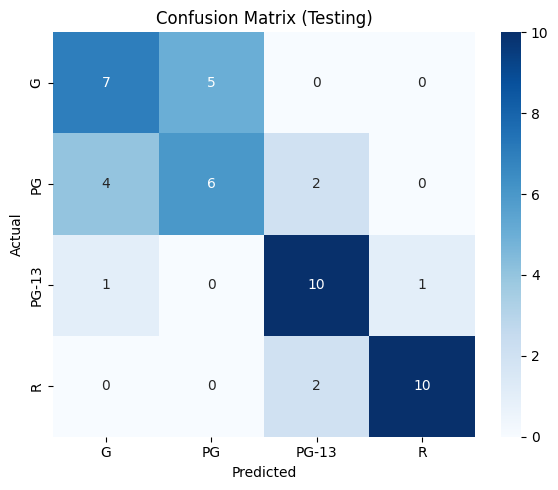

✅ Model dan file pendukung berhasil disimpan.


In [ ]:
import os
import pandas as pd
import numpy as np
import re
import json
import joblib
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

base_path = '/kaggle/input/file-srt/Dataset srt'  

def clean_text(text):
    text = re.sub(r'\d+:\d+:\d+,\d+ --> \d+:\d+:\d+,\d+', '', text)  
    text = re.sub(r'\[.*?\]|\(.*?\)|\{.*?\}', '', text)  
    text = re.sub(r'\d+', '', text)  
    text = re.sub(r'[^\w\s]', '', text)  
    text = text.lower().strip()
    return text

def preprocess_text(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return ' '.join(tokens)

def load_data(base_path):
    texts, labels = [], []
    categories = ['G', 'PG', 'PG-13', 'R']
    
    for category in categories:
        folder = os.path.join(base_path, category)
        if not os.path.exists(folder):
            continue
        for file in os.listdir(folder):
            path = os.path.join(folder, file)
            try:
                with open(path, 'r', encoding='utf-8', errors='ignore') as f:
                    content = f.read()
                    if content.strip():
                        processed = preprocess_text(content)
                        if len(processed.split()) > 5:
                            texts.append(processed)
                            labels.append(category)
            except Exception as e:
                print(f"❌ Gagal membaca {path}: {e}")
    
    return pd.DataFrame({'text': texts, 'label': labels})

df = load_data(base_path)
print(f"Jumlah data: {len(df)}")
print("Distribusi label:\n", df['label'].value_counts())

X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)

vectorizer = TfidfVectorizer(
    max_features=200,
    ngram_range=(1, 2),
    min_df=4,
    max_df=0.9
)

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

model = MultinomialNB(alpha=0.1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, digits=4, output_dict=True)
print("=== CLASSIFICATION REPORT (Testing) ===")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=sorted(df['label'].unique()))
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(df['label'].unique()),
            yticklabels=sorted(df['label'].unique()))
plt.title('Confusion Matrix (Testing)')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

import joblib
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', model)
])
joblib.dump(pipeline, 'complete_pipeline.pkl')

joblib.dump(vectorizer, 'vectorizer.pkl')
joblib.dump(model, 'naive_bayes_classifier.pkl')
np.save('feature_names.npy', vectorizer.get_feature_names_out())

model_info = {
    "alpha": 0.1,
    "vectorizer": {
        "max_features": 200,
        "ngram_range": (1, 2),
        "min_df": 4,
        "max_df": 0.9
    },
    "classification_report": report,
    "labels": sorted(df['label'].unique())
}
with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)

print("✅ Model dan file pendukung berhasil disimpan.")


In [6]:
!zip -r naivebayes_.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/vectorizer.pkl (deflated 55%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/naive_bayes_classifier.pkl (deflated 8%)
  adding: kaggle/working/model_info.json (deflated 76%)
  adding: kaggle/working/complete_pipeline.pkl (deflated 55%)
  adding: kaggle/working/feature_names.npy (deflated 46%)


In [7]:
from IPython.display import FileLink
FileLink(r'naivebayes_.zip')

/kaggle/working/naivebayes_.zip